#  ***STEP 1: Import libraries***

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.filters import threshold_otsu, threshold_sauvola


# ***STEP 2: Dataset path & structure check***

In [2]:
DATASET_PATH = "/kaggle/input/datasets/masoudnickparvar/brain-tumor-mri-dataset"

print("Main folders:", os.listdir(DATASET_PATH))

for split in ["Training", "Testing"]:
    print(f"\n{split} classes:", os.listdir(os.path.join(DATASET_PATH, split)))


Main folders: ['Training', 'Testing']

Training classes: ['pituitary', 'notumor', 'meningioma', 'glioma']

Testing classes: ['pituitary', 'notumor', 'meningioma', 'glioma']


# ***STEP 3: Dataset summary (images per class)***


In [3]:
summary = []

for split in ["Training", "Testing"]:
    for cls in os.listdir(os.path.join(DATASET_PATH, split)):
        cls_path = os.path.join(DATASET_PATH, split, cls)
        summary.append([split, cls, len(os.listdir(cls_path))])

df = pd.DataFrame(summary, columns=["Split", "Class", "Images"])
df


,Split,Class,Images
0,Training,pituitary,1457
1,Training,notumor,1595
2,Training,meningioma,1339
3,Training,glioma,1321
4,Testing,pituitary,300
5,Testing,notumor,405
6,Testing,meningioma,306
7,Testing,glioma,300


# ***STEP 4: Pick ONE sample image (for segmentation demo)***

In [4]:
img_path = os.path.join(
    DATASET_PATH,
    "Training",
    "glioma",
    os.listdir(os.path.join(DATASET_PATH, "Training", "glioma"))[0]
)

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))


# ***STEP 5: Otsu (Global Thresholding)***

In [5]:
otsu_thresh = threshold_otsu(img)
otsu_mask = (img > otsu_thresh).astype(np.uint8)


# ***STEP 6: Sauvola (Adaptive Thresholding)***

In [6]:
s_thresh = threshold_sauvola(img, window_size=25, k=0.2)
sauvola_mask = (img > s_thresh).astype(np.uint8)


# ***STEP 7: Create Pseudo Ground Truth***   

In [7]:
kernel = np.ones((5,5), np.uint8)
gt_mask = cv2.morphologyEx(sauvola_mask, cv2.MORPH_CLOSE, kernel)
 # Dataset has NO real masks, so we create pseudo GT.

# ***STEP 8: Dice & Jaccard functions***

In [8]:
def dice_score(pred, gt):
    intersection = np.sum(pred * gt)
    return (2 * intersection) / (np.sum(pred) + np.sum(gt) + 1e-7)

def jaccard_score(pred, gt):
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    return intersection / (union + 1e-7)


# ***STEP 9: Compute scores***

In [9]:
print("Otsu Dice Score:", dice_score(otsu_mask, gt_mask))
print("Sauvola Dice Score:", dice_score(sauvola_mask, gt_mask))

print("Otsu Jaccard Score:", jaccard_score(otsu_mask, gt_mask))
print("Sauvola Jaccard Score:", jaccard_score(sauvola_mask, gt_mask))


Otsu Dice Score: 0.6764911540025641
Sauvola Dice Score: 0.9374382364109927
Otsu Jaccard Score: 0.5111345919964291
Sauvola Jaccard Score: 0.8822435255383312


# ***STEP 10: Visualization (single image)***

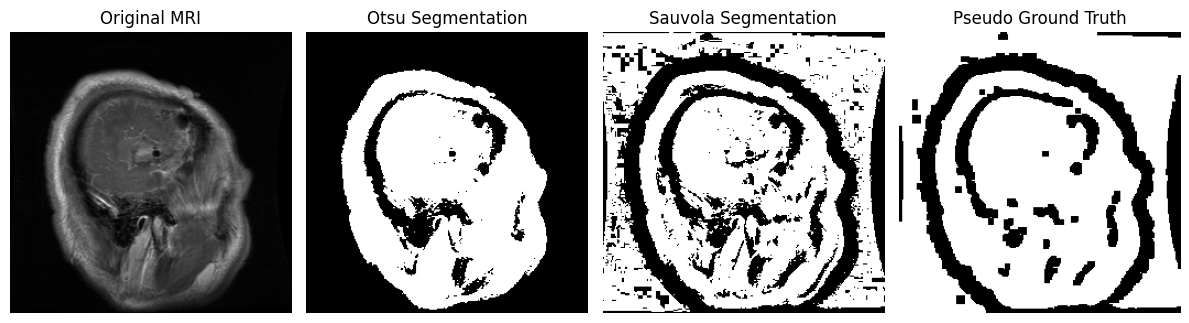

In [10]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.imshow(img, cmap="gray")
plt.title("Original MRI")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(otsu_mask, cmap="gray")
plt.title("Otsu Segmentation")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(sauvola_mask, cmap="gray")
plt.title("Sauvola Segmentation")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(gt_mask, cmap="gray")
plt.title("Pseudo Ground Truth")
plt.axis("off")

plt.tight_layout()
plt.show()


# ***STEP 11: Visualization for ALL categories***

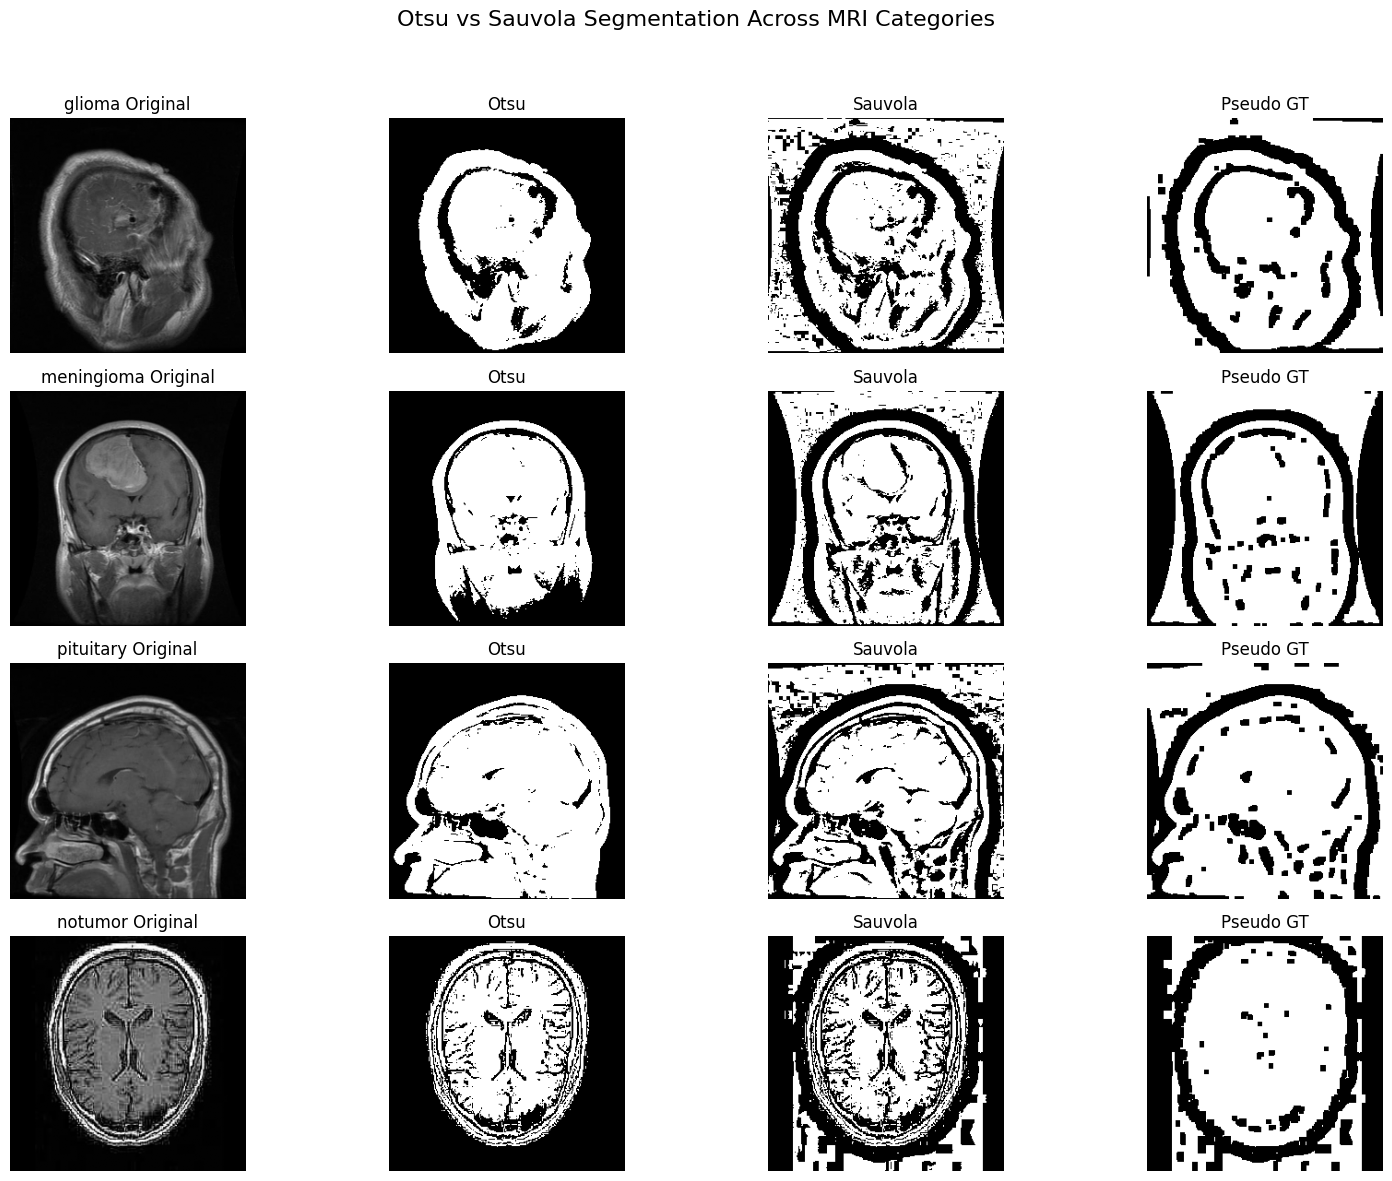

In [11]:
categories = ["glioma", "meningioma", "pituitary", "notumor"]
TRAIN_PATH = os.path.join(DATASET_PATH, "Training")

plt.figure(figsize=(16, 12))
row = 1

for cat in categories:
    cls_path = os.path.join(TRAIN_PATH, cat)
    img_name = os.listdir(cls_path)[0]
    img_path = os.path.join(cls_path, img_name)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (256, 256))

    otsu_mask = (img > threshold_otsu(img)).astype(np.uint8)
    sauvola_mask = (img > threshold_sauvola(img, 25, 0.2)).astype(np.uint8)
    gt_mask = cv2.morphologyEx(sauvola_mask, cv2.MORPH_CLOSE, np.ones((5,5),np.uint8))

    plt.subplot(len(categories),4,(row-1)*4+1)
    plt.imshow(img, cmap="gray"); plt.title(f"{cat} Original"); plt.axis("off")

    plt.subplot(len(categories),4,(row-1)*4+2)
    plt.imshow(otsu_mask, cmap="gray"); plt.title("Otsu"); plt.axis("off")

    plt.subplot(len(categories),4,(row-1)*4+3)
    plt.imshow(sauvola_mask, cmap="gray"); plt.title("Sauvola"); plt.axis("off")

    plt.subplot(len(categories),4,(row-1)*4+4)
    plt.imshow(gt_mask, cmap="gray"); plt.title("Pseudo GT"); plt.axis("off")

    row += 1

plt.suptitle("Otsu vs Sauvola Segmentation Across MRI Categories", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()
